# 3.1 Homographies
- A homography is a 2D projective transformation that maps points in one plane to another.
- Plane : images or planar surfaces in 3D.
- Use for registering images, rectifying images, texture warping, creating panoramas.
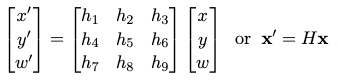
- Poins in homogeneous coordinates are only defined up to scale so that x = [x, y, w] = [alpha x, alpha y, alpha w] = [x/w, y/w, 1] all refer to the same 2D point.
- homography H is also only defined up to scale and has eight independent degrees of freedom.
- Often points are normalized with w = 1 to have a unique identification of the image coordinates x, y.

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2

def normalize(points):
    '''
    Normalize a collection of points in
    homogeneous coordinates so that last row = 1
    '''
    
    for row in points:
        row /= points[-1]
    return points

def make_homog(points):
    '''
    Convert a set of points (dim *n array) to
    homogeneous coordinates.
    '''
    
    return vstack((points, np.ones((1, points.shape[1]))))

- store the poins column-wise so that a set of n points in 2-D will be a 3xn array in homo coordinates.
- This format makes matrix multiplications and point transforms easier.
##### affine transformation
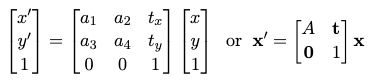
- preserves w = 1 and cannot represent as strong deformations as a full projective transformation.
- Invertible matrix A and a translation vector t = [tx, ty]
- Preserve line, ratio of distance, parallelism
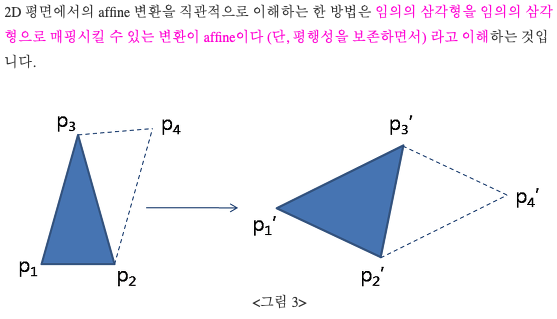
##### similarity transformation
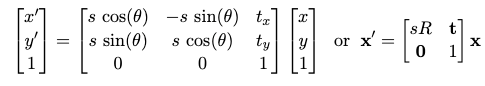
- It is a rigid 2D transformation that also includes scale changes.
- the scalar s specifies scaling, R is a rotation of an angle theta and t = [tx, ty] is again a translation.
- with s = 1 -> distances are preserved and it is then a rigid transformation!!!!!!
- Used for example in image registration.

### The direct linear transformation algorithm
- DLT (direct linear transformation)
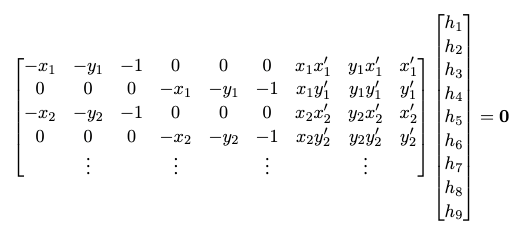 or Ah = 0
- Homographies can be computed directly from corresponding points in two images.
- each point correspondence gives two equations, one each for the x, y
- four point correspondences are needed to compute H (two images -> 4 points)

In [2]:
def H_from_points(fp, tp):
    '''
    Find homography H, such that fp is mapped to tp
    using the linear DLT emthod.
    Points are conditioned automatically.
    '''
    if fp.shape != tp.shape:
        raise RuntimeError('number of points do not match')
        
    # condition points (important for numerical reasons)
    # --from points--
    m = np.mean(fp[:2], axis = 1)
    maxstd = np.max(np.std(fp[:2], axis = 1)) + 1e-9
    C1 = np.diag([1/maxstd, 1/maxstd, 1])
    C1[0][2] = -m[0] / maxstd
    C1[1][2] = -m[1] / maxstd
    fp = C1.dot(fp)
    
    # --to points--
    m = np.mean(tp[:2], axis = 1)
    maxstd = np.max(np.std(tp[:2], axis = 1)) + 1e-9
    C2 = np.diag([1/maxstd, 1/maxstd, 1])
    C2[0][2] = -m[0] / maxstd
    C2[1][2] = -m[1] / maxstd
    tp = C2.dot(tp)
    
    # create matrix for linear method, 2 rows for each correspondence pair
    nbr_correspondences = fp.shape[1]
    A = np.zeros((2*nbr_correspondences, 9))
    for i in range(nbr_correspondences):
        A[2*i] = [-fp[0][i], -fp[1][i], -1, 0, 0, 0,
                   tp[0][i]*fp[0][i], tp[0][i]*fp[1][i], tp[0][i]]
        A[2*i+1] = [0, 0, 0, -fp[0][i], -fp[1][i], -1,
                   tp[1][i]*fp[0][i], tp[1][i]*fp[1][i], tp[1][i]]
        
    U, S, V = np.linalg.svd(A)
    H = V[8].reshape((3, 3))
    
    # decondition
    H = np.dot(np.linalg.inv(C2), np.dot(H, C1))
    
    # normalize and return
    return H / H[2, 2]

### Affine transformations
- 6 degrees of freedom -> 3 point correspondences are needed to estimate H.
- an be estimated using the DLT algorithm above by setting the last two elements equal to zero, h7 = h8 = 0

In [42]:
def Haffine_from_points(fp, tp):
    '''
    Find H, affine transformation, such that
    tp is affine transformation of fp.
    '''
    if fp.shape != tp.shape:
        raise RuntimeError('number of points do not match')
        
    # condition points (important for numerical reasons)
    # --from points--
    m = np.mean(fp[:2], axis = 1)
    maxstd = np.max(np.std(fp[:2], axis = 1)) + 1e-9
    C1 = np.diag([1/maxstd, 1/maxstd, 1])
    C1[0][2] = -m[0] / maxstd
    C1[1][2] = -m[1] / maxstd
    fp_cond = C1.dot(fp)
    
    # --to points--
    m = np.mean(tp[:2], axis = 1)
    C2 = C1.copy() # must use same scaling for both point sets    
    C2[0][2] = -m[0] / maxstd
    C2[1][2] = -m[1] / maxstd
    tp_cond = C2.dot(tp)
    
    # conditioned points have mean zero, so translation is zero.
    A = np.concatenate((fp_cond[:2], tp_cond[:2]), axis = 0)
    U, S, V = np.linalg.svd(A.T)
    
    # create B and C matrices as Hartley-Zisserman
    tmp = V[:2].T
    B = tmp[:2]
    C = tmp[2:4]
    
    tmp2 = np.concatenate((np.dot(C, np.linalg.pinv(B)), np.zeros((2,1))), axis=1)
    H = np.vstack((tmp2,[0,0,1]))
  
    # decondition
    H = np.dot(np.linalg.inv(C2), np.dot(H,C1))
    
    return H / H[2,2]

# 3.2 Warping images
- applying an affine transformation matrix H on image patches is called warping (or affine warping)
- warped image is filled with zeros outside the borders of the warped area to create a binary alpha map.

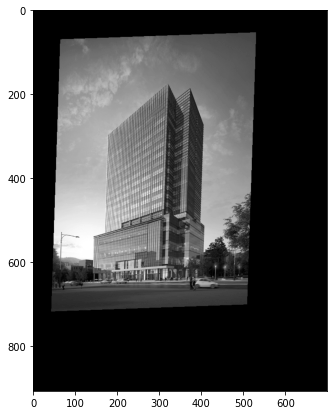

In [9]:
# transformed_im = ndimage.affine_transform(im, A, b, size)
# transforms the image patch 'im' with 'A' a linear transformation.
# 'b' a translation vector.

from scipy import ndimage

im = np.array(Image.open('building.jpg').convert('L'))
H = np.array([[1.4, 0.05, -100], [0.05, 1.5, -100], [0, 0, 1]])
im2 = ndimage.affine_transform(im, H[:2, :2], (H[0, 2], H[1, 2]))

plt.figure(figsize = (10, 7))
plt.gray()
plt.imshow(im2)
plt.show()

In [16]:
H = np.array([[1.4, 0.05, -100], [0.05, 1.5, -100], [0, 0, 1]])

print(H[:2, :2])
print(H[0, 2], H[1, 2])

[[1.4  0.05]
 [0.05 1.5 ]]
-100.0 -100.0


906 700


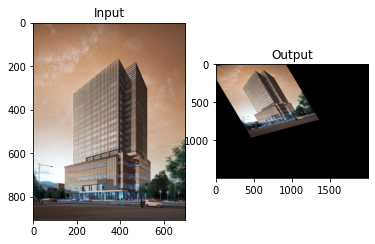

In [35]:
import cv2

img = cv2.imread('building.jpg')
rows, cols, ch = img.shape

pts1 = np.float32([[50,50],[200,50],[50,200]])
pts2 = np.float32([[10,100],[200,50],[100,250]])

M = cv2.getAffineTransform(pts1,pts2)

dst = cv2.warpAffine(img,M,(2000,1500))
plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

### Image in image
- place images, or parts of images, inside another image.

In [36]:
def image_in_image(im1,im2,tp):
    """
    Put im1 in im2 with an affine transformation
    such that corners are as close to tp as possible.
    tp are homogeneous and counter-clockwise from top left.
    """
    # points to warp from
    m,n = im1.shape[:2]
    fp = np.array([[0,m,m,0],[0,0,n,n],[1,1,1,1]])
    
    # compute affine transform and apply
    H = Haffine_from_points(tp,fp)
    im1_t = ndimage.affine_transform(im1,H[:2,:2],
                                     (H[0,2],H[1,2]),im2.shape[:2])
    alpha = (im1_t > 0)
    
    return (1-alpha)*im2 + alpha*im1_t

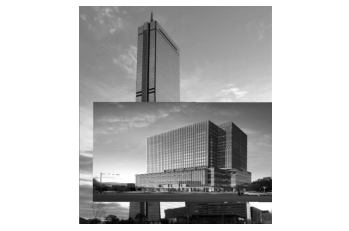

In [43]:
im1 = np.array(Image.open('building.jpg').convert('L'))
im2 = np.array(Image.open('631.jpg').convert('L'))

tp = np.array([[264,538,540,264],[40,36,605,605],[1,1,1,1]])

im3 = image_in_image(im1,im2,tp)

plt.figure()
plt.gray()
plt.imshow(im3)
plt.axis('equal')
plt.axis('off')
plt.show()

### Piecewise affine warping
- warp that image to corresponding landmarks in another image by triangulating the points into a triangle mesh and then warping each triangle with an affine transform

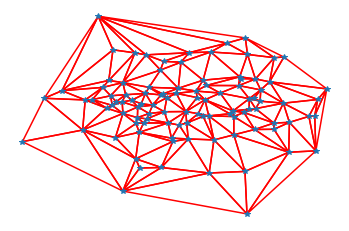

In [63]:
from scipy.spatial import Delaunay

np.random.seed(123)
x, y = np.array(np.random.standard_normal((2, 100)))
tri = Delaunay(np.c_[x,y]).simplices

plt.figure()
for t in tri:
    t_ext = [t[0], t[1], t[2], t[0]] # add first point to end
    plt.plot(x[t_ext], y[t_ext], 'r')
    
plt.plot(x, y, '*')
plt.axis('off')
plt.show()

# 3.3 Creating Panoramas
- More than two images that are taken at the same location are homographically related.
- stitch together into one big mosaic.

### RANSAC (RANdom SAmple Consensus)
- iterative method to fit models to data that can contain outliers.

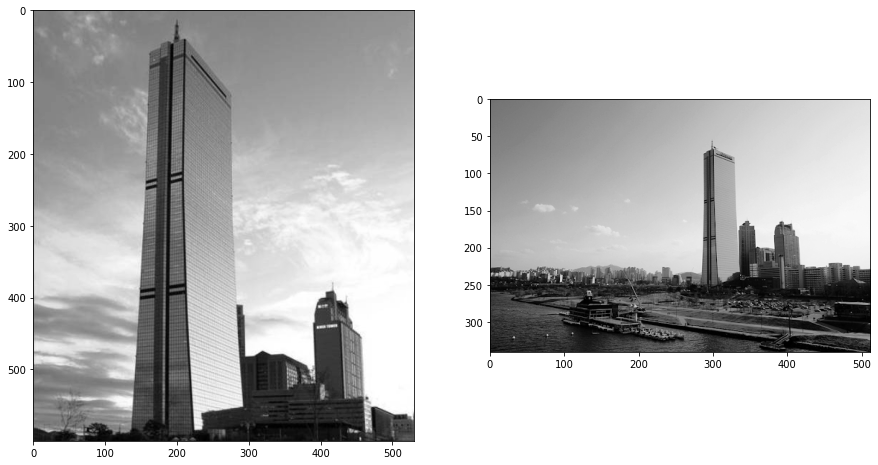

In [27]:
img1 = cv2.imread('631.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread('632.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

f, ax = plt.subplots(1, 2, figsize = (15, 8))

ax[0].imshow(img1, cmap = 'gray')
ax[1].imshow(img2, cmap = 'gray')

In [28]:
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)

print(len(keypoints_1), len(keypoints_2))

1139 557


In [22]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(descriptors_1,descriptors_2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [24]:
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ keypoints_1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints_2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

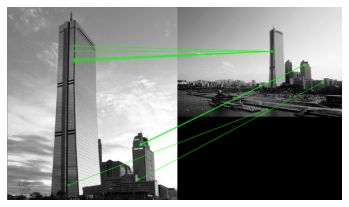

(<matplotlib.image.AxesImage at 0x1324eda00>,
 (-0.5, 1041.5, 599.5, -0.5),
 None)

In [30]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,keypoints_1,img2,keypoints_2,good,None,**draw_params)

plt.imshow(img3, 'gray'), plt.axis('off'),plt.show()

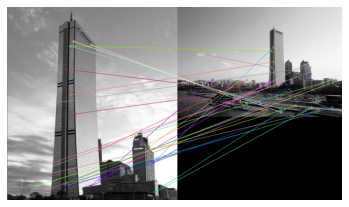

In [29]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = True)

matches = bf.match(descriptors_1, descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:30], img2, flags = 2)
plt.imshow(img3)
plt.axis('off')
plt.show()